In [5]:
import numpy as np
from sklearn.covariance import GraphicalLasso
import matplotlib.pyplot as plt

np.random.seed(42)
X = np.load('params_matrix.npy')
n_features = X.shape[1]
alpha = 0.01  # 正则化参数（调整稀疏性）
glmodel = GraphicalLasso(alpha=alpha, max_iter=100)

glmodel.fit(X)

# 获取精度矩阵（inverse covariance）
precision_matrix = glmodel.precision_

# 获取协方差矩阵
covariance_matrix = glmodel.covariance_

# 检查精度矩阵的稀疏性
sparsity = np.sum(precision_matrix == 0) / (n_features** 2)
print(f"Sparsity of the precision matrix: {sparsity:.4f}")

Sparsity of the precision matrix: 0.9998


In [6]:
import nfode
import torch
import torch.nn as nn
data = np.load('data_test.npz')
t_data = data['t_data']
x_data = data['x_data']

input_dim=2
output_dim=2
inner_dim=64
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, inner_dim)
        self.fc3 = nn.Linear(inner_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = torch.load('model.pt')
x0 = x_data[:, 0]
x_data = torch.tensor(x_data)
x_preds = nfode.predict(model, t_data, x0)
x_preds = x_preds.reshape(1000,2)
loss = nn.MSELoss()
x_preds = torch.tensor(x_preds).requires_grad_(True)

/tmp/ipykernel_51843/4060854076.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pt')
/tmp/ipykernel_51843/4060854076.py:29: UserWarning: To co

In [7]:
from scipy.stats import multivariate_normal
n_features = X.shape[1]

mu = np.zeros(n_features)
covariance_matrix = glmodel.covariance_

# 检查协方差矩阵的正定性（必要条件）
if np.all(np.linalg.eigvals(covariance_matrix) > 0):
    print("Covariance matrix is positive definite. Ready for sampling.")

Covariance matrix is positive definite. Ready for sampling.


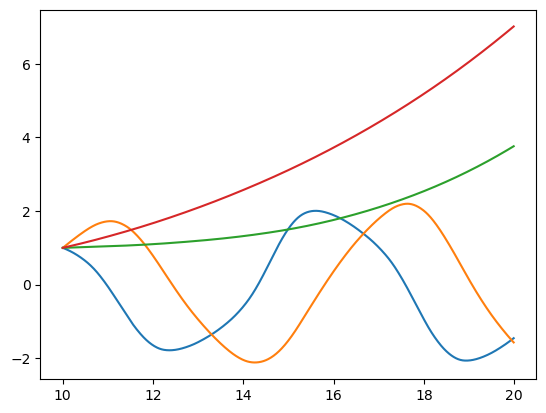

In [17]:
sample = np.random.multivariate_normal(mean=mu, cov=covariance_matrix)
sample = sample.reshape(-1)
params, flat_params, param_types, param_shapes = nfode.flatten_params(model)
modified_model = nfode.update_model_params(model, sample, param_shapes)
x_modified_preds = nfode.predict(modified_model, t_data, x0)
plt.plot(t_data, x_preds.detach().numpy())
plt.plot(t_data, x_modified_preds.reshape(1000,2))